# Setup
This notebook requires the deepface package to be installed. In case something goes wrong, here are the steps to set up the environment from scratch:

1. conda create --name deepface python=3.9
2. conda activate deepface
3. pip install deepface
4. conda install glib
5. pip install albumentations
6. conda install ipykernel
7. ipython kernel install --user --name=deepface
8. conda install opencv matplotlib numpy -y

Modules are then imported, followed by the setup of constants, classes and functions.

In [1]:
# Module / package imports
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os
import random
from deepface.commons import functions

import MyDeepFace

ROOT_DIR     = os.path.dirname(os.path.realpath("__file__"))
IMG_ROOT_DIR = os.path.join(ROOT_DIR, "dataset")

#                0    ,     1    ,      2      ,     3     ,      4      ,      5     ,     6    ,   7
BACKENDS = [  "opencv",     "ssd",       "dlib",    "mtcnn", "retinaface", "mediapipe"]
MODELS   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",   "DeepFace",    "DeepID", "ArcFace", "Dlib"]

In [2]:
# Function definitions
def show_batch_images(img_paths, num=1, start=0, shuffle=False):
    """
    Plots a batch of 'num' images from the list 'img_paths' which
    contains the full path to each image. Starts from 'start' image.
    If 'shuffle' is True, then the 'img_paths' list is shuffled first.
    
    Inputs:
        1. img_paths - list containing full path to each image
        
        2. num - number of images to be shown ([num=1])
        
        3. start - start from 'start' image ([start=0])
        
        4. shuffle - shuffles the image paths list ([shuffle=False])
        
    Output:
      None
      
    Example calls:
        show_batch_images(paths, num=4, start=2)
        show_batch_images(paths, num=3, shuffle=True)
        
    """
    if num <= 0:
        num = 1
    
    if shuffle:
        random.shuffle(img_paths)
    
    assert len(img_paths[start]) >= num, "Not enough images."
    
    for i, path in enumerate(img_paths[start:]):
        if i >= num:
            break
        
        plt.imshow(mpimg.imread(path))
        plt.title(path.split("/")[-1])
        plt.show()

# ============================================================================

def plot_face_detections(img_path, rois, figsize = (8, 6),
                         linewidth=1, edgecolor='r'):
    """
    Plots the original image with the face detections overlaid as red rectangles.
    
    Inputs:
        1. img_path - image path, base64 image or image as a numpy array.
        2. rois - list of region of interests ([top-left x, top-left y, width,
            height])
        3. figsize - 2 element tupple specifying figure size ([figsize = (8, 6)])
        4. linewidth - positive number specifying the line width ([linewidth = 1])
        5. edgecolor - character specifying the rectangles' color ([edgecolor = 'r'])
        
    Output:
        1. fig - handle to the plotted figure
        
    Example call:
        fig = plot_face_detections(img_path, rois)
    """
    
    # Loads image. Image might be path, base64 or numpy array.
    # Convert it to numpy whatever it is.
    img = functions.load_image(img_path)
    
    # Plot figure
    fig, ax = plt.subplots(1, figsize = figsize)
    plt.imshow(img)
    
    # Loops through each region of interest (roi) and plots
    # it over the original image
    for roi in rois:
        # Skip region plotting if no faces were detected
        if len(roi) == 0:
            continue
        
        rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3],
                                 linewidth = linewidth, edgecolor = edgecolor,
                                 facecolor='none')
        ax.add_patch(rect)
        
    return fig


# Data set exploration
We first define the relative path to our data set, which is just a directory filled with images. We also use the *show_batch_images* function to show 2 random images.

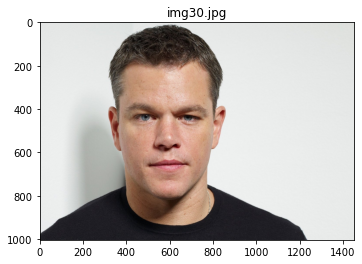

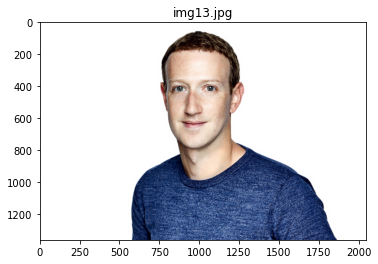

In [3]:
# Obtain all image paths
img_paths = [os.path.join(IMG_ROOT_DIR, path) for path in os.listdir(IMG_ROOT_DIR) \
             if path.startswith("img") and path.endswith(".jpg")]

# Show a batch of images
show_batch_images(img_paths, num=2, shuffle=True)
img_paths.sort() # sorts after shuffle

# Face detection

We define a target image and use a chosen face detector to detect the faces in it. There are 6 types of face detectors: opencv, ssd, dlib, mtcnn, retinaface, mediapipe. The face region is shown as a red rectangle over the original image and the cropped (and aligned) face is also shown.

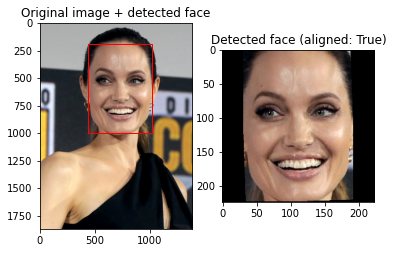

In [4]:
# Define the target image - this can be changed
TARGET_IMG = img_paths[0]

# Detects faces
output = MyDeepFace.detect_faces(TARGET_IMG, target_size = (224, 224),
                                 detector_backend = BACKENDS[4], align = True,
                                 return_type='both')

# Plotting sequence
fig, axs = plt.subplots(1, 2)
axs[0].imshow(mpimg.imread(TARGET_IMG))
axs[1].imshow(output["faces"][0][0, :, :, ::-1])

# Add rectangle to identify face area
roi  = output["regions"][0]
rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3],
                         linewidth=1, edgecolor='r', facecolor='none')
axs[0].add_patch(rect)

# Add title
axs[0].title.set_text("Original image + detected face")
axs[1].title.set_text("Detected face (aligned: True)")

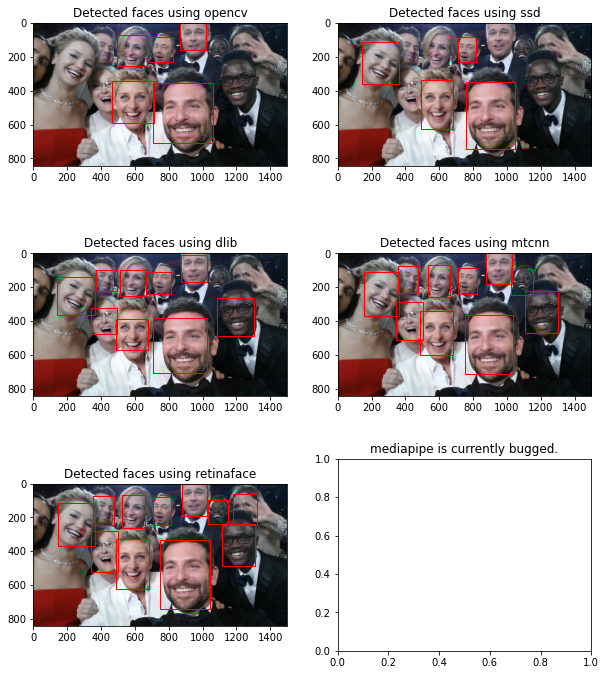

In [5]:
import requests
from PIL import Image
from io import BytesIO

FILE_URL = "https://img.playbuzz.com/image/upload/c_crop/q_auto:good,f_auto,fl_lossy,w_640,c_limit,dpr_2.5/v1529570769/myuuxslhz7udhdxj0ihh.jpg"

# Obtain image
r   = requests.get(FILE_URL)
img = Image.open(BytesIO(r.content))

# Create array of axes corresponding to a 2 x 2 grid
fig2, axs = plt.subplots(3, 2, figsize=(10, 12));
axs = [item for ax_list in axs for item in ax_list]

outputs = []
for i in range(6):
    if i == 5:
        axs[i].title.set_text(f"{BACKENDS[i]} is currently bugged.")
        continue
    
    # Detects faces (regions)
    output = MyDeepFace.detect_faces(img_path=FILE_URL, target_size=(224, 224),
                                     detector_backend=BACKENDS[i], return_type='regions')
    outputs.append(output['regions'])
    
    # Plots image
    axs[i].imshow(img)

    for roi in outputs[i]:
        # Skip region plotting if no faces were detected
        if len(roi) == 0:
            continue
        
        # Draw and plot rectangle
        rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3],
                                 linewidth=1, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)
    
    axs[i].title.set_text(f"Detected faces using {BACKENDS[i]}")

# Face verification

We compare a target image to a reference image and determine if they are the same person. The face detector and verifier models are also shown. The main difference between face verification and recognition, at this stage, is that the face recognition requires runing the face verifier across a set (database) of images. 

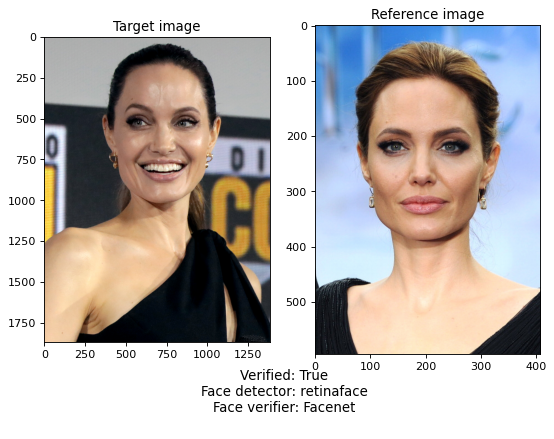

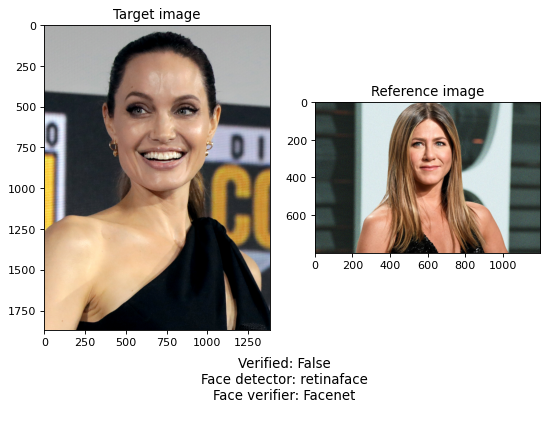

In [6]:
# Setting target and test images - these can be changed
TARGET_IMG = img_paths[0]
REF_IMG1   = img_paths[1]  # positive match with target
REF_IMG2   = img_paths[50] # negative match with target

# Runs verification
pos_verification = MyDeepFace.verify(img1_path = TARGET_IMG, img2_path = REF_IMG1,
                                     model_name = MODELS[1], detector_backend = BACKENDS[4])
neg_verification = MyDeepFace.verify(img1_path = TARGET_IMG, img2_path = REF_IMG2,
                                     model_name = MODELS[1], detector_backend = BACKENDS[4])

# Plotting sequences
fig1, axs1 = plt.subplots(1, 2, figsize=(8, 6), dpi=80)
axs1[0].imshow(mpimg.imread(TARGET_IMG))
axs1[0].title.set_text("Target image")

axs1[1].imshow(mpimg.imread(REF_IMG1))
axs1[1].title.set_text("Reference image")

# Add text
txt1 = f"Verified: {pos_verification['verified']}\nFace detector: {pos_verification['detector_backend']}\nFace verifier: {pos_verification['model']}\n"
plt.figtext(0.5, 0.01, txt1, wrap=True, horizontalalignment='center', fontsize=12);

# Plotting sequence
fig2, axs2 = plt.subplots(1, 2, figsize=(8, 6), dpi=80)
axs2[0].imshow(mpimg.imread(TARGET_IMG))
axs2[0].title.set_text("Target image")

axs2[1].imshow(mpimg.imread(REF_IMG2))
axs2[1].title.set_text("Reference image")

# Add text
txt2 = f"Verified: {neg_verification['verified']}\nFace detector: {neg_verification['detector_backend']}\nFace verifier: {neg_verification['model']}\n"
plt.figtext(0.5, 0.01, txt2, wrap=True, horizontalalignment='center', fontsize=12);

# Facial attribute analysis

Face attribute analysis is the extraction of information by analysing the face. More specifically, here we are trying to determine the age, gender, race and emotion of the person in the target image from their face alone. The attributes are shown along with the original image with the face region overlaid on top. The race and emotions shown are the dominant ones, that is, the most likely one.

Action: emotion: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


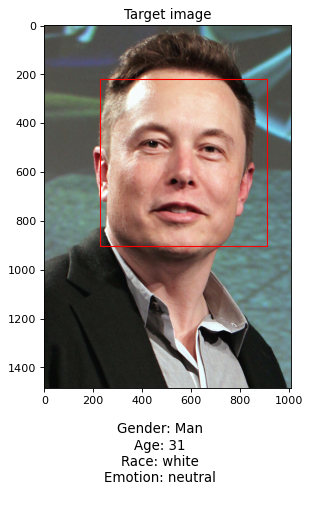

In [7]:
# Setting target image
TARGET_IMG = img_paths[10]

# Run age, gender, race and emotion analysis
obj = MyDeepFace.analyze(img_path = TARGET_IMG, actions = ['age', 'gender', 'race', 'emotion'])

# Plotting sequence
fig, ax = plt.subplots(1, figsize=(8, 6), dpi=80)
ax.imshow(mpimg.imread(TARGET_IMG))
ax.title.set_text("Target image")

# Add rectangle to identify face area
rect = patches.Rectangle((obj['region']['x'], obj['region']['y']),
                          obj['region']['w'], obj['region']['h'],
                          linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# Add text
txt = f"Gender: {obj['gender']}\nAge: {obj['age']}\nRace: {obj['dominant_race']}\nEmotion: {obj['dominant_emotion']}\n"
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12);